In [1]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from geopy.distance import distance

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df_turin = pd.read_csv("../data/raw/torino_rental.csv")

In [3]:
df_berlin = pd.read_csv("../data/raw/berlin_rental.csv")

In [4]:
df_milan = pd.read_csv("../data/raw/milan_rental.csv")

# Filtering and Data Prep

Removing invalid rentals (less than 3 mins, more than 1 hour, less than 700 meters). From: "Free Floating Electric Car Sharing in Smart Cities: Data Driven System Dimensioning" - Michele Cocca, Danilo Giorndano, Marco Mellia, Luca Vassio

In [5]:
def removeInvalidDistAndTime(df, lower_bound, upper_bound, min_distance): # min, min, meters
    df = df[df['duration'] < upper_bound]
    df = df[df['duration'] > lower_bound]
    df = df[df['distance'] > min_distance]
    return df

In [6]:
def distanceCalc (col): #calculates distance between two points
    start = tuple(eval(col)[0])
    stop = tuple(eval(col)[1])
    return distance(start, stop).meters

In [8]:
def colsPrep(df):
    df['duration'] = (df['final_time'] - df['init_time'])/60 #duration in minutes instead of seconds
    df['distance'] = df['origin_destination.coordinates'].apply(lambda x: distanceCalc(x))
    df['origin_coordinates'] = df['origin_destination.coordinates'].apply(lambda x: tuple(eval(x)[0]))
    df['final_coordinates'] = df['origin_destination.coordinates'].apply(lambda x: tuple(eval(x)[1]))
    df['init_date'] = df['init_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    df['final_date'] = df['final_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    df['init_hour'] = df['init_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%H'))
    df['final_hour'] = df['final_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%H'))
    #df['init_weekday'] = df['init_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())
    return df

In [9]:
df_turin = colsPrep(df_turin)
df_turin = removeInvalidDistAndTime(df_turin, 3, 60, 700) 

In [11]:
df_berlin = colsPrep(df_berlin)
df_berlin = removeInvalidDistAndTime(df_berlin, 3, 60, 700)

In [ ]:
df_milan = colsPrep(df_milan)
df_milan = removeInvalidDistAndTime(df_milan, 3, 60, 700)

In [10]:
# Save filtered dfs
#df_berlin.to_csv("../data/interim/df_berlin.csv")
#df_turin.to_csv("../data/interim/df_turin.csv")
#df_milan.to_csv("../data/interim/df_milan.csv")

In [3]:
# Load filtered dfs
df_berlin = pd.read_csv("../data/interim/df_berlin.csv")
df_turin =  pd.read_csv("../data/interim/df_turin.csv")
df_milan = pd.read_csv("../data/interim/df_milan.csv")

# Analysis of Number of Rentals

## Analysis of rentals per day

In [44]:
def findRentalsPerDay(df):
    # Groupby df according to init_date
    rentals_day = df['init_date'].value_counts().rename_axis('date').reset_index(name='rentals')
    rentals_day = rentals_day.sort_values(['date']).reset_index(drop = True)
    # Converts date to datetime object
    rentals_day['date'] = rentals_day['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
    return rentals_day

In [45]:
rentals_day_berlin = findRentalsPerDay(df_berlin)
rentals_day_turin = findRentalsPerDay(df_turin)
rentals_day_milan = findRentalsPerDay(df_milan)

In [321]:
# Save dfs
# rentals_day_berlin.to_csv("../data/interim/rentals_day_berlin.csv")
# rentals_day_turin.to_csv("../data/interim/rentals_day_turin.csv")
# rentals_day_milan.to_csv("../data/interim/rentals_day_milan.csv")

In [57]:
# Load dfs
#rentals_day_berlin = pd.read_csv("../data/interim/rentals_day_berlin.csv")
#rentals_day_turin = pd.read_csv("../data/interim/rentals_day_turin.csv")
#rentals_day_milan = pd.read_csv("../data/interim/rentals_day_milan.csv")

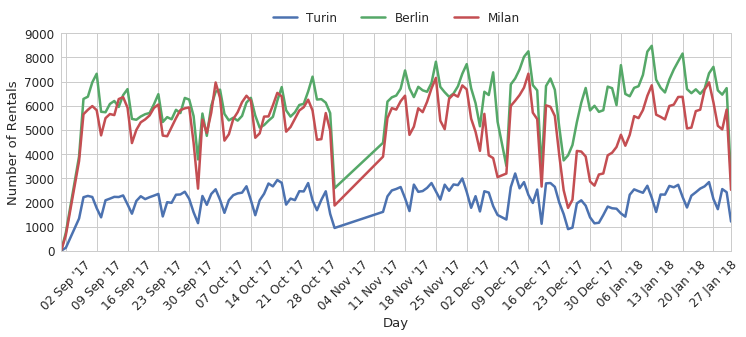

In [63]:
# Time series analysis overtime for rentals per day
x = rentals_day_turin['date']
y1 = rentals_day_turin['rentals']
y2 = rentals_day_berlin['rentals']
y3 = rentals_day_milan['rentals']

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.xticks(rotation=45)
plt.xlim(min(x), max(x))
plt.ylim(0, 9000)
plt.xlabel("Day")
plt.ylabel("Number of Rentals")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b \'%y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))   #to get a tick every 7 days

plt.plot(x,y1,label='Turin')
plt.plot(x,y2,label='Berlin')
plt.plot(x,y3,label='Milan')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)

## Analysis of rentals per hour

In [55]:
# Function to count how many rentals there was in an hour. If an event starts at X hour and stops at Y hour,
# (with Y being X+1) it is counted for both hours.
def getRentalsPerHourDict(df):
    # Dict to count rentals in an hour
    hours_dict = {"00": 0, "01": 0, "02": 0, "03": 0, "04": 0,
             "05": 0, "06": 0, "07": 0, "08": 0, "09": 0,
            "10": 0, "11": 0, "12": 0, "13": 0, "14": 0,
            "15": 0, "16": 0, "17": 0, "18": 0, "19": 0,
            "20": 0, "21": 0, "22": 0, "23": 0}
    
    # Populate hours with amount of cars in that hour
    for tuple in df.itertuples():
        for h in hours_dict:
            if tuple.init_hour == h or tuple.final_hour == h:
                hours_dict[h] += 1
    return hours_dict

In [47]:
#Gets average number of rentals per hour
def getRentalsPerHourAvg(n_days, df):
    hours_dict = getRentalsPerHourDict(df)
    rentals_hour = pd.DataFrame(list(hours_dict.items()), columns=['hour', 'rentals']).sort_values('hour')
    rentals_hour['rentals'] = rentals_hour['rentals']/n_days
    return rentals_hour

In [56]:
n_days_berlin = rentals_day_berlin.shape[0]
rentals_hour_berlin = getRentalsPerHourAvg(n_days_berlin, df_berlin)

In [57]:
n_days_turin = rentals_day_turin.shape[0]
rentals_hour_turin = getRentalsPerHourAvg(n_days_turin, df_turin)

In [58]:
n_days_milan = rentals_day_milan.shape[0]
rentals_hour_milan = getRentalsPerHourAvg(n_days_milan, df_milan)

In [320]:
# Save processed dataframes
# rentals_hour_berlin.to_csv("../data/interim/rentals_hour_berlin.csv")
# rentals_hour_turin.to_csv("../data/interim/rentals_hour_turin.csv")
# rentals_hour_milan.to_csv("../data/interim/rentals_hour_milan.csv")

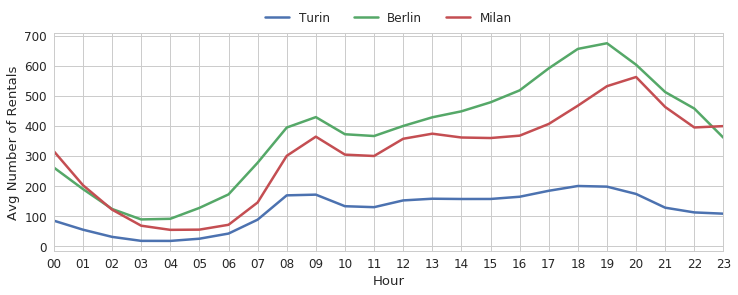

In [327]:
# PLot rentals per hour
x = rentals_hour_turin['hour']
y1 = rentals_hour_turin['rentals']
y2 = rentals_hour_berlin['rentals']
y3 = rentals_hour_milan['rentals']

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.xlim(0, 23)
plt.xlabel("Hour")
plt.ylabel("Avg Number of Rentals")

plt.plot(x,y1,label='Turin')
plt.plot(x,y2,label='Berlin')
plt.plot(x,y3,label='Milan')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)

## Average number of rentals per weekday

In [56]:
def calcAvgPerWeekday(df):
    # Count number of each weekday
    dates = df['init_date'].unique()
    weekdays = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
    for date in dates:
        weekdays[datetime.datetime.strptime(date, '%Y-%m-%d').weekday()] += 1
    # Avg per weekday
    df['init_weekday'] = df['init_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())
    rentals_weekday = pd.DataFrame(df.groupby(['init_weekday']).mean())
    rentals_weekday = df['init_weekday'].value_counts().rename_axis('weekday').reset_index(name='rentals')
    rentals_weekday = rentals_weekday.sort_values(['weekday']).reset_index(drop = True)
    rentals_weekday["number_weekdays"] = pd.DataFrame.from_dict(weekdays, orient='index')
    rentals_weekday['avg_rentals'] = rentals_weekday['rentals']/rentals_weekday['number_weekdays']
    return rentals_weekday

In [57]:
rentals_weekday_turin = calcAvgPerWeekday(df_turin)

In [58]:
rentals_weekday_berlin = calcAvgPerWeekday(df_berlin)
rentals_weekday_milan = calcAvgPerWeekday(df_milan)

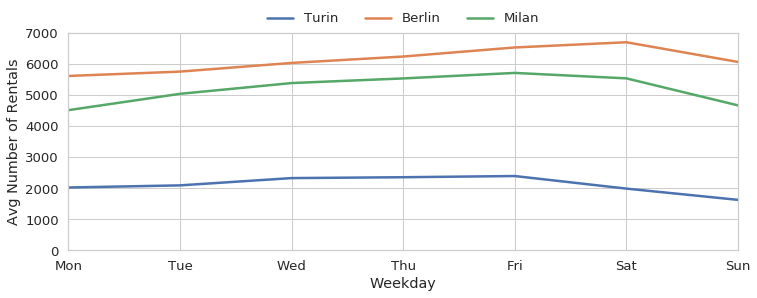

In [65]:
# Plot of avg rental
x = rentals_weekday_turin['weekday']
y1 = rentals_weekday_turin['avg_rentals']
y2 = rentals_weekday_berlin['avg_rentals']
y3 = rentals_weekday_milan['avg_rentals']

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.xticks((0,1,2,3,4,5,6),("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"))
plt.xlabel("Weekday")
plt.ylabel("Avg Number of Rentals")
plt.ylim(0, 7000)
plt.xlim(0, 6)

plt.plot(x,y1,label='Turin')
plt.plot(x,y2,label='Berlin')
plt.plot(x,y3,label='Milan')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)

# CDF (Cumulative Density Function)

## CDF for rental duration

In [29]:
# Creation of dfs with sorted duration values in min
duration_cdf_turin = pd.DataFrame(df_turin['duration'].apply(lambda x: float(x)))
duration_cdf_turin = duration_cdf_turin.sort_values('duration')

In [26]:
duration_cdf_berlin = pd.DataFrame(df_berlin['duration'].apply(lambda x: float(x)))
duration_cdf_berlin = duration_cdf_berlin.sort_values('duration')

In [27]:
duration_cdf_milan = pd.DataFrame(df_milan['duration'].apply(lambda x: float(x)))
duration_cdf_milan = duration_cdf_milan.sort_values('duration')

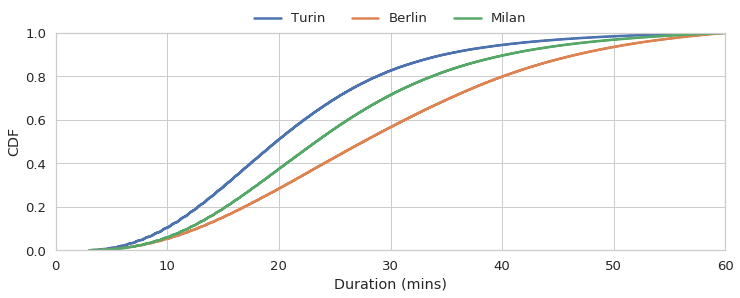

In [30]:
# Plot of cdf for rental duration
x1 = duration_cdf_turin
x2 = duration_cdf_berlin
x3 = duration_cdf_milan

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.xlim(0, 60)
plt.ylim(0, 1)
plt.xlabel("Duration (mins)")
plt.ylabel("CDF")

p1 = 1. * np.arange(len(x1))/(len(x1) - 1)
p2 = 1. * np.arange(len(x2))/(len(x2) - 1)
p3 = 1. * np.arange(len(x3))/(len(x3) - 1)

plt.plot(x1, p1, label = "Turin")
plt.plot(x2, p2, label = "Berlin")
plt.plot(x3, p3, label = "Milan")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)

## CDF for rental driving distance

Distance multiplied by 1.4 - correction factor from: "Free Floating Electric Car Sharing in Smart Cities: Data Driven System Dimensioning" - Michele Cocca, Danilo Giorndano, Marco Mellia, Luca Vassio, which is a factor calculated by the difference between the euclidean distance and the distance given by Google Maps

In [34]:
# Creation of dfs with sorted distances values in km
distance_cdf_turin = pd.DataFrame(df_turin['distance'].apply(lambda x: float(x))*1.4/1000) 
distance_cdf_turin = distance_cdf_turin.sort_values('distance')

In [35]:
distance_cdf_berlin = pd.DataFrame(df_berlin['distance'].apply(lambda x: float(x)*1.4)/1000)
distance_cdf_berlin = distance_cdf_berlin.sort_values('distance')
distance_cdf_berlin = distance_cdf_berlin[:-2] # Removal of invalid data

In [36]:
distance_cdf_milan = pd.DataFrame(df_milan['distance'].apply(lambda x: float(x)*1.4)/1000)
distance_cdf_milan = distance_cdf_milan.sort_values('distance')

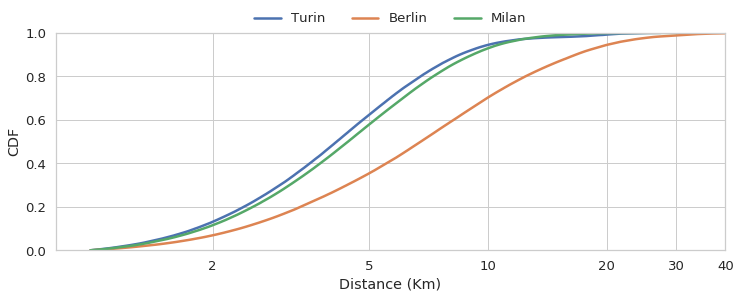

In [39]:
x1 = distance_cdf_turin
x2 = distance_cdf_berlin
x3 = distance_cdf_milan

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

p1 = 1. * np.arange(len(x1))/(len(x1) - 1)
p2 = 1. * np.arange(len(x2))/(len(x2) - 1)
p3 = 1. * np.arange(len(x3))/(len(x3) - 1)

plt.xscale('log') #changed x scale to log for better visualization
plt.xticks([2, 5, 10, 20, 30, 40], (2, 5, 10, 20, 30, 40))
plt.xlim(0.8, 40)
plt.ylim(0, 1)
plt.xlabel("Distance (Km)")
plt.ylabel("CDF")

plt.plot(x1, p1, label = "Turin")
plt.plot(x2, p2, label = "Berlin")
plt.plot(x3, p3, label = "Milan")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon = False)

# Analysis of rental duration

## Analysis of rental duration for each hour

Group by according to rental's starting hour. 

In [4]:
duration_hour_turin = df_turin.groupby(['init_hour'])['duration'].mean().rename_axis('hour').reset_index(name = 'duration')
duration_hour_turin = pd.DataFrame(duration_hour_turin)

In [5]:
duration_hour_berlin = df_berlin.groupby(['init_hour'])['duration'].mean().rename_axis('hour').reset_index(name = 'duration')
duration_hour_berlin = pd.DataFrame(duration_hour_berlin)

In [6]:
duration_hour_milan = df_milan.groupby(['init_hour'])['duration'].mean().rename_axis('hour').reset_index(name = 'duration')
duration_hour_milan = pd.DataFrame(duration_hour_milan)

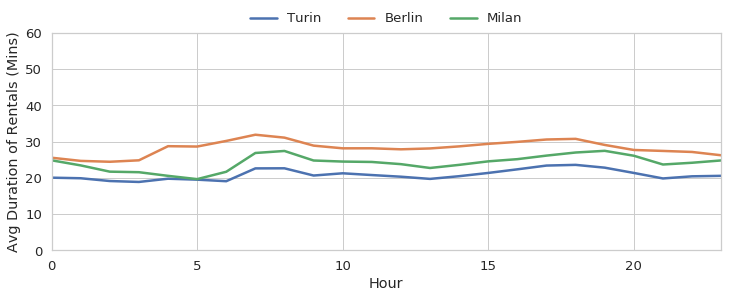

In [26]:
# PLot rentals per hour
x = duration_hour_turin['hour']
y1 = duration_hour_turin['duration']
y2 = duration_hour_berlin['duration']
y3 = duration_hour_milan['duration']

sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.xlim(0, 23)
plt.ylim(0, 60)
plt.xlabel("Hour")
plt.ylabel("Avg Duration of Rentals (Mins)")

plt.plot(x,y1,label='Turin')
plt.plot(x,y2,label='Berlin')
plt.plot(x,y3,label='Milan')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, frameon=False)

## Stats about the data for Turin

Shows how the duration is distributed for each hour.

(0, 70)

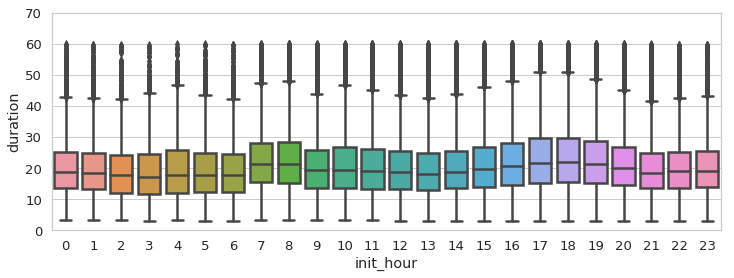

In [28]:
ax = sns.boxplot(x="init_hour", y="duration", data=df_turin)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

#ax.xaxis.set_ticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_ylim(0, 70)

Plot for specific hours (rush hours)

Text(0, 0.5, 'Density')

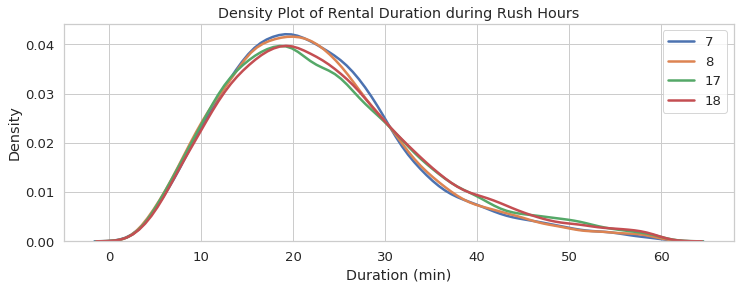

In [47]:
hours = [7, 8, 17, 18]

# Iterate through the hours
for hour in hours:
    subset = df_turin[df_turin['init_hour'] == hour]
     
    # Draw the density plot
    sns.distplot(subset['duration'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2.5},
                 label = hour)
    
# Plot formatting
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1})
plt.title('Density Plot of Rental Duration during Rush Hours')
plt.xlabel('Duration (min)')
plt.ylabel('Density')

## Analysis of duration per weekday

Group by according to the date that the rental started. 

In [7]:
duration_day_turin = pd.DataFrame(df_turin.groupby(['init_date'])['duration'].mean())
duration_day_turin = duration_day_turin.reset_index().sort_values(["init_date"]).reset_index(drop=True)

In [8]:
# Defines which weekday a date is
duration_day_turin['init_weekday'] = duration_day_turin['init_date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())

(16, 26)

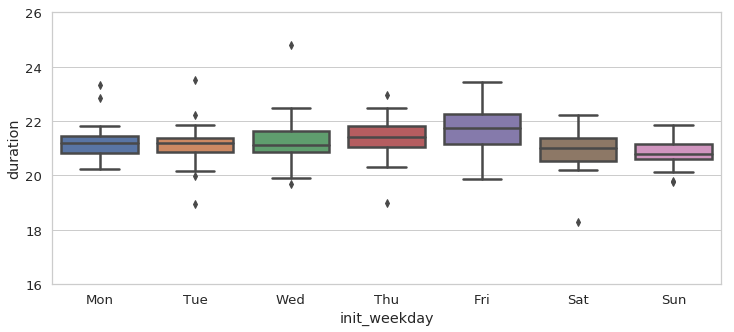

In [13]:
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

ax = sns.boxplot(x="init_weekday", y="duration", data=duration_day_turin)
ax.xaxis.set_ticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
ax.set_ylim(16, 26)